<a href="https://colab.research.google.com/github/jeffreymas/Deteksi-Penyakit-tanaman/blob/master/DeteksiPenyakit_tanaman_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Plant Disease Diagnosis Model with PlantVillage Dataset

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('default')
from skimage.io import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import keras
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.utils.data_utils import get_file

from keras import layers
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Persiapan

## Pengambilan Data 

In [2]:
!apt-get install subversion > /dev/null

#Retreive specifc diseases of tomato for training
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Bacterial_spot image/Tomato___Bacterial_spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Early_blight image/Tomato___Early_blight　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Late_blight image/Tomato___Late_blight　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Septoria_leaf_spot image/Tomato___Septoria_leaf_spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Target_Spot image/Tomato___Target_Spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___healthy image/Tomato___healthy　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Tomato_mosaic_virus image/Tomato___mosaic_virus >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Spider_mites%20Two-spotted_spider_mite image/Tomato___Spider_mites_20Two-spotted_spider_mite >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Leaf_Mold image/Tomato___Leaf_Mold >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus image/Tomato___Yellow_Leaf_Curl_Virus >  /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cbb image/Cassava___cbb > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cbsd image/Cassava___cbsd > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cgm image/Cassava___cgm > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cmd image/Cassava___cmd > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/healthy image/Cassava___healthy > /dev/null

svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Bacterial_spot　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Early_blight　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Late_blight　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Septoria_leaf_spot　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___Target_Spot　' already exists
svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'image/Tomato___healthy　' already exists
svn: E155000: Destination directory exi

In [3]:
#folder structure
!ls image

Cassava___cbb		   Tomato___Late_blight　
Cassava___cbsd		   Tomato___Leaf_Mold
Cassava___cgm		   Tomato___mosaic_virus
Cassava___cmd		   Tomato___Septoria_leaf_spot　
Cassava___healthy	   Tomato___Spider_mites_20Two-spotted_spider_mite
Tomato___Bacterial_spot　  Tomato___Target_Spot　
Tomato___Early_blight　    Tomato___Yellow_Leaf_Curl_Virus
Tomato___healthy　


Tomato___Target_Spot　


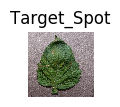

Cassava___cmd


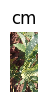

Tomato___Yellow_Leaf_Curl_Virus


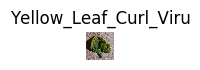

Tomato___healthy　


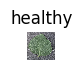

Tomato___Leaf_Mold


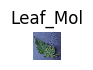

Tomato___Bacterial_spot　


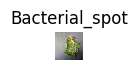

Tomato___mosaic_virus


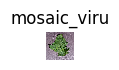

Tomato___Early_blight　


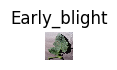

Cassava___cbsd


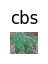

Cassava___healthy


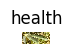

Tomato___Late_blight　


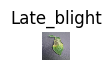

Cassava___cgm


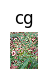

Tomato___Septoria_leaf_spot　


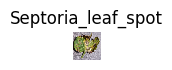

Tomato___Spider_mites_20Two-spotted_spider_mite


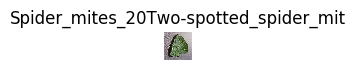

Cassava___cbb


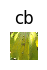

In [4]:
plt.figure(figsize=(15,10))

#visualize several images

parent_directory = "image"

for i, folder in enumerate(os.listdir(parent_directory)):
    print(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    file = files[0] 
    file_path = os.path.join(folder_directory,file)
    
    image = imread(file_path)
    plt.subplot(1,15,i+1)
    plt.imshow(image)
    plt.axis("off")
    
    name = folder.split("___")[1][:-1]
    plt.title(name)
    plt.show()

In [5]:
#load everything into memory
x = []
y = []
class_names = []
parent_directory = "image"

for i,folder in enumerate(os.listdir(parent_directory)):
    print(i,folder)
    class_names.append(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    for file in files:
        file_path = os.path.join(folder_directory,file)
        image = load_img(file_path,target_size=(64,64))
        image = img_to_array(image)/255.
        x.append(image)
        y.append(i)

x = np.array(x)
y = to_categorical(y)

0 Tomato___Target_Spot　
1 Cassava___cmd
2 Tomato___Yellow_Leaf_Curl_Virus
3 Tomato___healthy　
4 Tomato___Leaf_Mold
5 Tomato___Bacterial_spot　
6 Tomato___mosaic_virus
7 Tomato___Early_blight　
8 Cassava___cbsd
9 Cassava___healthy
10 Tomato___Late_blight　
11 Cassava___cgm
12 Tomato___Septoria_leaf_spot　
13 Tomato___Spider_mites_20Two-spotted_spider_mite
14 Cassava___cbb


In [6]:
#check the data shape
print(x.shape)
print(y.shape)
print(y[0])

(23816, 64, 64, 3)
(23816, 15)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
x_train, _x, y_train, _y = train_test_split(x,y,test_size=0.2, stratify = y, random_state = 1)
x_valid,x_test, y_valid, y_test = train_test_split(_x,_y,test_size=0.4, stratify = _y, random_state = 1)

print("train data:",x_train.shape,y_train.shape)
print("validation data:",x_valid.shape,y_valid.shape)
print("test data:",x_test.shape,y_test.shape)


train data: (19052, 64, 64, 3) (19052, 15)
validation data: (2858, 64, 64, 3) (2858, 15)
test data: (1906, 64, 64, 3) (1906, 15)


In [8]:
import tensorflow as tf
IMG_SHAPE = (64, 64, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [9]:
base_model.trainable = True
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32) 

## Model Preparation

In [13]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 2, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 2, 2, 1024)        3228864   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 32)          131104    
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                495       
Total params: 3,360,463
Trainable params: 3,338,575
Non-trainable params: 21,888
_________________________________________________________________


## Training

In [0]:
#utilize early stopping function to stop at the lowest validation loss
#es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
#utilize save best weight model during training
ckpt = ModelCheckpoint("DeteksiPenyakitTanaman.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [0]:
#we will define a generator class for training data and validation data seperately, as no augmentation is not required for validation data
t_gen = ImageDataGenerator(rotation_range=90,horizontal_flip=True)
v_gen = ImageDataGenerator()
train_gen = t_gen.flow(x_train,y_train,batch_size=98)
valid_gen = v_gen.flow(x_valid,y_valid,batch_size=98)

In [16]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.n // 98,
    callbacks = [ckpt],
    #callbacks = [es,ckpt],
    validation_data = valid_gen,
    validation_steps = valid_gen.n // 98,
    
    epochs=5)

Epoch 1/5
 29/194 [===>..........................] - ETA: 5s - loss: 1.1886 - acc: 0.6823
Epoch 00001: val_loss improved from inf to 1.18860, saving model to DeteksiPenyakitTanaman.hdf5
194/194 [==============================] - 35s 183ms/step - loss: 0.9728 - acc: 0.7027 - val_loss: 1.1886 - val_acc: 0.6823
Epoch 2/5
 29/194 [===>..........................] - ETA: 2s - loss: 0.8069 - acc: 0.7716
Epoch 00002: val_loss improved from 1.18860 to 0.80691, saving model to DeteksiPenyakitTanaman.hdf5
194/194 [==============================] - 23s 117ms/step - loss: 0.5267 - acc: 0.8236 - val_loss: 0.8069 - val_acc: 0.7716
Epoch 3/5
 29/194 [===>..........................] - ETA: 2s - loss: 1.1299 - acc: 0.7020
Epoch 00003: val_loss did not improve from 0.80691
194/194 [==============================] - 22s 114ms/step - loss: 0.4275 - acc: 0.8543 - val_loss: 1.1299 - val_acc: 0.7020
Epoch 4/5
 29/194 [===>..........................] - ETA: 2s - loss: 0.8161 - acc: 0.7745
Epoch 00004: val_loss

## Evaluation

In [0]:
#load the model weight file with lowest validation loss
model.load_weights("DeteksiPenyakitTanaman.hdf5")

In [18]:
#check the model metrics
print(model.metrics_names)
#evaluate training data
print(model.evaluate(x= x_train, y = y_train))
#evaluate  validation data
print(model.evaluate(x= x_valid, y = y_valid))
#evaluate  test data
print(model.evaluate(x= x_test, y = y_test))      

['loss', 'acc']
19052/19052 [==============================] - 4s 209us/sample - loss: 0.4296 - acc: 0.8510
[0.4296078306147463, 0.8510393]
2858/2858 [==============================] - 1s 220us/sample - loss: 0.4707 - acc: 0.8450
[0.4707242897793161, 0.8449965]
1906/1906 [==============================] - 0s 228us/sample - loss: 0.4287 - acc: 0.8562
[0.42868411397133394, 0.85624343]


In [19]:
#draw a confusion matrix

#true label
y_true = np.argmax(y_test,axis=1)

#prediction label
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[ 2  3 10 ...  4  4  4]
[ 2  3 10 ...  4  4  4]


Normalized confusion matrix
[[0.84 0.   0.   0.   0.   0.   0.04 0.07 0.   0.   0.   0.   0.01 0.04
  0.  ]
 [0.   0.73 0.   0.   0.   0.   0.   0.   0.21 0.04 0.   0.01 0.   0.
  0.01]
 [0.   0.   0.96 0.   0.02 0.01 0.   0.01 0.   0.   0.   0.   0.   0.
  0.  ]
 [0.01 0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02
  0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.01 0.
  0.  ]
 [0.01 0.   0.01 0.   0.   0.95 0.   0.02 0.   0.   0.   0.   0.01 0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.93 0.   0.   0.06 0.   0.01 0.
  0.  ]
 [0.   0.06 0.   0.   0.   0.   0.   0.01 0.8  0.05 0.   0.01 0.   0.
  0.07]
 [0.   0.12 0.   0.   0.   0.   0.   0.   0.44 0.36 0.   0.   0.   0.
  0.08]
 [0.   0.   0.   0.01 0.   0.01 0.   0.01 0.01 0.   0.95 0.   0.02 0.
  0.  ]
 [0.   0.4  0.   0.   0.   0.   0.   0.   0.35 0.18 0.   0.03 0.   0.
  0.03]
 [0.01 0.   0.   0.   0.01 0.   

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0.0, flags=flags)


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0, flags=flags)


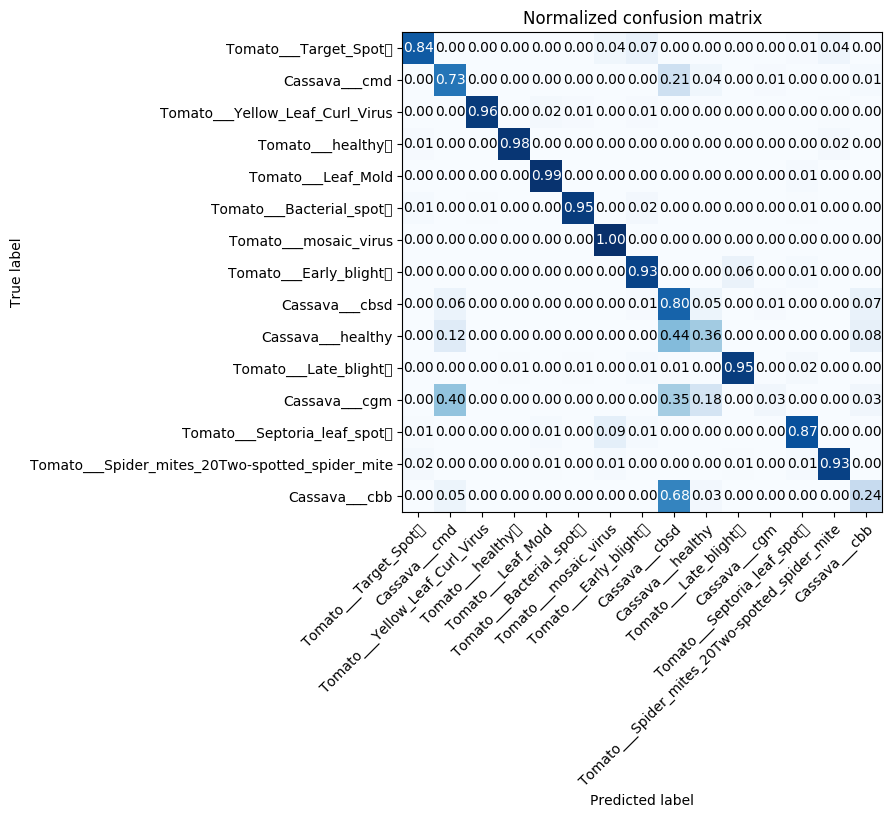

In [20]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')



## Predicting Indivisual Images

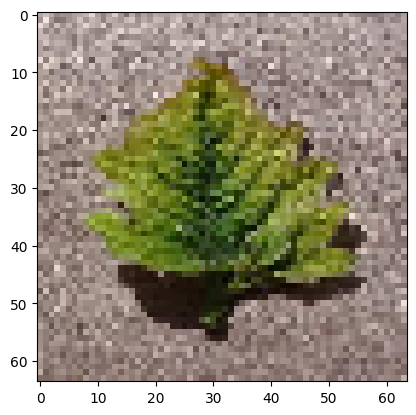

Gambar Yang Benar Adalah: 2 : Tomato___Yellow_Leaf_Curl_Virus
prediksi Value: [2.61e-05 6.43e-07 9.99e-01 2.55e-09 4.03e-04 5.00e-07 1.99e-07 4.50e-05
 1.31e-09 2.35e-06 3.48e-05 1.01e-05 1.94e-06 8.08e-05 6.45e-07]
prediksi gambar: 2 : Tomato___Yellow_Leaf_Curl_Virus
Prediksi Benar


In [21]:
n = 99 #do not exceed (number of test image - 1)

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test,axis=1)[n]
print("Gambar Yang Benar Adalah:",true_label,":",class_names[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("prediksi Value:",prediction)
predicted_label = np.argmax(prediction)
print("prediksi gambar:",predicted_label,":",class_names[predicted_label])

if true_label == predicted_label:
    print("Prediksi Benar")
else:
    print("Prediksi Salah")

In [22]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)